In [1]:
import pandas as pd
import numpy as np
import missingno as mn

In [2]:
breed_stats = pd.read_csv('./datasets/breeds_info_clean.csv')


In [3]:
breed_stats.head(3)

,breed,classification,obey,reps_lower,reps_upper,height_low_inches,height_high_inches,weight_low_lbs,weight_high_lbs
0,border collie,brightest dogs,0.95,1.0,4.0,19.0,21.0,40.0,40.0
1,poodle,brightest dogs,0.95,1.0,4.0,NaN,NaN,NaN,NaN
2,german shepherd,brightest dogs,0.95,1.0,4.0,22.0,26.0,75.0,90.0


In [4]:
breeds = set(breed_stats['breed'])

In [5]:
shelter = pd.read_csv('./datasets/cleaned_data/texas_shelters_active.csv')

/Users/genebob/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,8,10,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
shelter.head(3)

,id,breed,color,dob,sex,date_in,age_in,intact_in,location,intake_type,...,date_out,age_out,intact_out,outcome,age,primary_color,secondary_color,breed_1,breed_2,pure
0,A047759,dachshund,Tricolor,1.080864e+09,1.0,1.396454e+09,10.0,0.0,Austin (TX),surrender,...,1.396884e+09,10.0,0.0,transfer,Senior,tricolor,tricolor,dachshund,dachshund,1.0
1,A134067,shetland sheepdog,Brown/White,8.769600e+08,1.0,1.384593e+09,16.0,0.0,12034 Research Blvd in Austin (TX),public_assist,...,1.384603e+09,16.0,0.0,owner_return,Senior,brown,white,shetland sheepdog,shetland sheepdog,1.0
2,A141142,labrador retriever/pit bull,Black/White,8.966592e+08,0.0,1.384613e+09,15.0,0.0,Austin (TX),stray,...,1.384688e+09,15.0,0.0,owner_return,Senior,black,white,labrador retriever,pit bull,NaN


In [7]:
shelter.columns

Index(['id', 'breed', 'color', 'dob', 'sex', 'date_in', 'age_in', 'intact_in',
       'location', 'intake_type', 'intake_subtype', 'condition', 'date_out',
       'age_out', 'intact_out', 'outcome', 'age', 'primary_color',
       'secondary_color', 'breed_1', 'breed_2', 'pure'],
      dtype='object')

In [8]:
shelter.drop(columns=['id', 'color', 'dob', 'age_in', 'intact_in', 'location', 'intake_subtype'])

,breed,sex,date_in,intake_type,condition,date_out,age_out,intact_out,outcome,age,primary_color,secondary_color,breed_1,breed_2,pure
0,dachshund,1.0,1.396454e+09,surrender,wnl,1.396884e+09,10.0,0.0,transfer,Senior,tricolor,tricolor,dachshund,dachshund,1.0
1,shetland sheepdog,1.0,1.384593e+09,public_assist,med_attn,1.384603e+09,16.0,0.0,owner_return,Senior,brown,white,shetland sheepdog,shetland sheepdog,1.0
2,labrador retriever/pit bull,0.0,1.384613e+09,stray,aged,1.384688e+09,15.0,0.0,owner_return,Senior,black,white,labrador retriever,pit bull,NaN
3,miniature schnauzer,0.0,1.415978e+09,stray,wnl,1.415993e+09,15.0,1.0,owner_return,Senior,black,gray,miniature schnauzer,miniature schnauzer,1.0
4,lhasa apso,1.0,1.410780e+09,stray,wnl,1.410799e+09,15.0,0.0,owner_return,Senior,brown,white,lhasa apso,lhasa apso,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132613,chihuahua,NaN,1.576541e+09,stray,other,1.576541e+09,NaN,NaN,owner_return,Adult,NaN,NaN,chihuahua,chihuahua,1.0
132614,chihuahua,NaN,1.576541e+09,stray,wnl,1.576541e+09,NaN,NaN,owner_return,Adult,NaN,NaN,chihuahua,chihuahua,1.0
132615,french bulldog,NaN,1.576541e+09,stray,other,1.576541e+09,NaN,NaN,owner_return,Adult,NaN,NaN,french bulldog,french bulldog,1.0
132616,bulldog,NaN,1.576541e+09,stray,wnl,1.576541e+09,NaN,NaN,owner_return,Adult,NaN,NaN,bulldog,bulldog,1.0


In [9]:
shelter['pure'].fillna(0, inplace=True)

<AxesSubplot:>

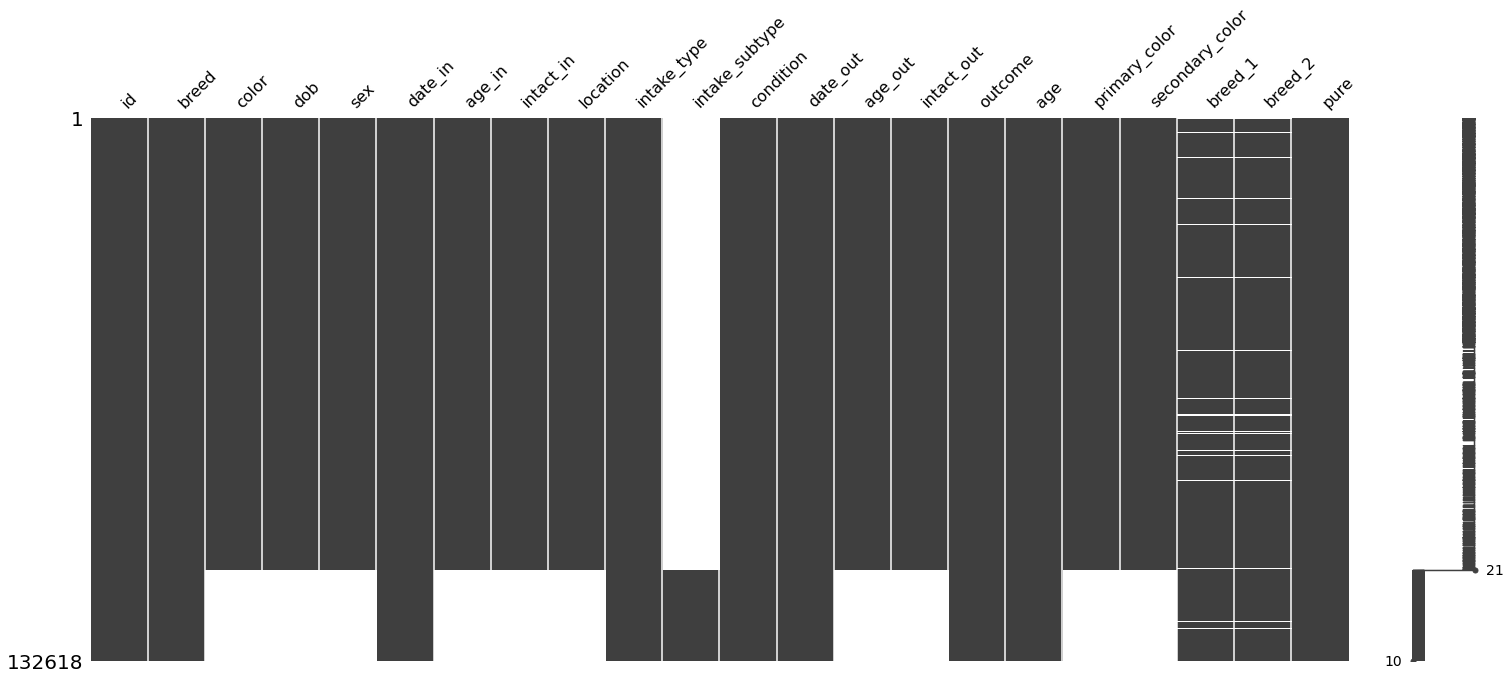

In [10]:
mn.matrix(shelter)

In [11]:
breed_stats.columns

Index(['breed', 'classification', 'obey', 'reps_lower', 'reps_upper',
       'height_low_inches', 'height_high_inches', 'weight_low_lbs',
       'weight_high_lbs'],
      dtype='object')

In [12]:
breed_stats.set_index('breed')

,classification,obey,reps_lower,reps_upper,height_low_inches,height_high_inches,weight_low_lbs,weight_high_lbs
breed,,,,,,,,
border collie,brightest dogs,0.95,1.0,4.0,19.0,21.0,40.0,40.0
poodle,brightest dogs,0.95,1.0,4.0,NaN,NaN,NaN,NaN
german shepherd,brightest dogs,0.95,1.0,4.0,22.0,26.0,75.0,90.0
golden retriever,brightest dogs,0.95,1.0,4.0,21.0,24.0,55.0,75.0
doberman pinscher,brightest dogs,0.95,1.0,4.0,26.0,28.0,60.0,100.0
...,...,...,...,...,...,...,...,...
miniature poodle,NaN,NaN,NaN,NaN,10.0,15.0,20.0,20.0
shetland sheepdog (sheltie),NaN,NaN,NaN,NaN,13.0,16.0,14.0,20.0
silky terrier,NaN,NaN,NaN,NaN,9.0,10.0,8.0,11.0


In [13]:
def gen_breed_stats(x):
    if x in breeds:
        stats = breed_stats
        return stats.set_index('breed').loc[x,:]

def compile_stats(x):
    pass


In [14]:
gen_breed_stats('poodle')

classification        brightest dogs
obey                            0.95
reps_lower                       1.0
reps_upper                       4.0
height_low_inches                NaN
height_high_inches               NaN
weight_low_lbs                   NaN
weight_high_lbs                  NaN
Name: poodle, dtype: object